# Fitting COVID19 trends using Bayesian method

In this assignment, our goal is to fit the COVID 19 trends (confirmed cases of COVID 19 as a function of date) using the generalized growth model given by

\begin{align}
\frac{d C(t)}{dt} = r C(t)^p, \label{eq:ode} \tag{1}
\end{align}

where $t \in [0,T]$ is the time (in units of days), $r \geq 0$ is the growth rate, $p
\in [0,1]$ is the 'decceleration of growth' parameter, see **Viboud et al 2015**. Special cases: $p = 0$ gives linear growth model and $p=1$ gives exponential growth model. 

$C : [0,T] \to [0, \infty)$ is the total confirmed COVID 19 cases at time $t$. When $0 < p < 1$, Eq (1) can be solved to get 

\begin{align}
C(t) = \left( \frac{r}{m}t + (C_0)^{1/m} \right)^m, \label{eq:model} \tag{2}
\end{align}

where $m = 1/(1 - p)$ and $C_0 = C(0)$ is the initial condition. For special cases $p=0$ and $p=1$, $C$ can be found easily.

# Problem

We cosider COVID 19 data at discrete times $\bar{t} = (t_1=0, t_2=1, ..., t_N=83)$, where $N = 84$, and corresponding total confirmed cases $Y(\bar{t}) = (Y_1, Y_2, ..., Y_N)$.

Model prediction is $C(\bar{t}) = (C(t_1), C(t_2), ..., C(t_N))$ where $C(t_i)$ is given by Eq (2). The model parameters are $\theta = (r, p)$. Take uniform prior for $\theta$ and consider a Guassian noise with zero mean and standard deviation $\sigma$. Divide the data in calibration and validation by taking first $N_c = 50$ as the calibration data and rest $N_v = N - N_c$ as validation data. You can also try different priors for parameters and divide data differently in calibration and validation set.

Problem: Predict the total confirmed cases at $T = 100$ day for three countries US, Japan, and South Korea.

## Data
Data for current epidemic COVID 19 can be found in several places such as:

- [datasets/covid-19](https://github.com/datasets/covid-19)

- [CSSEGISandData/COVID-19](https://github.com/CSSEGISandData/COVID-19)

- [nytimes/covid-19-data](https://github.com/nytimes/covid-19-data)


In [StudyCovid19](https://github.com/prashjha/StudyCovid19) you will find python scripts to process data and this notebook in directory `process/bayesian`.


Below we plot the confirmed cases for various countries

Num days: 84


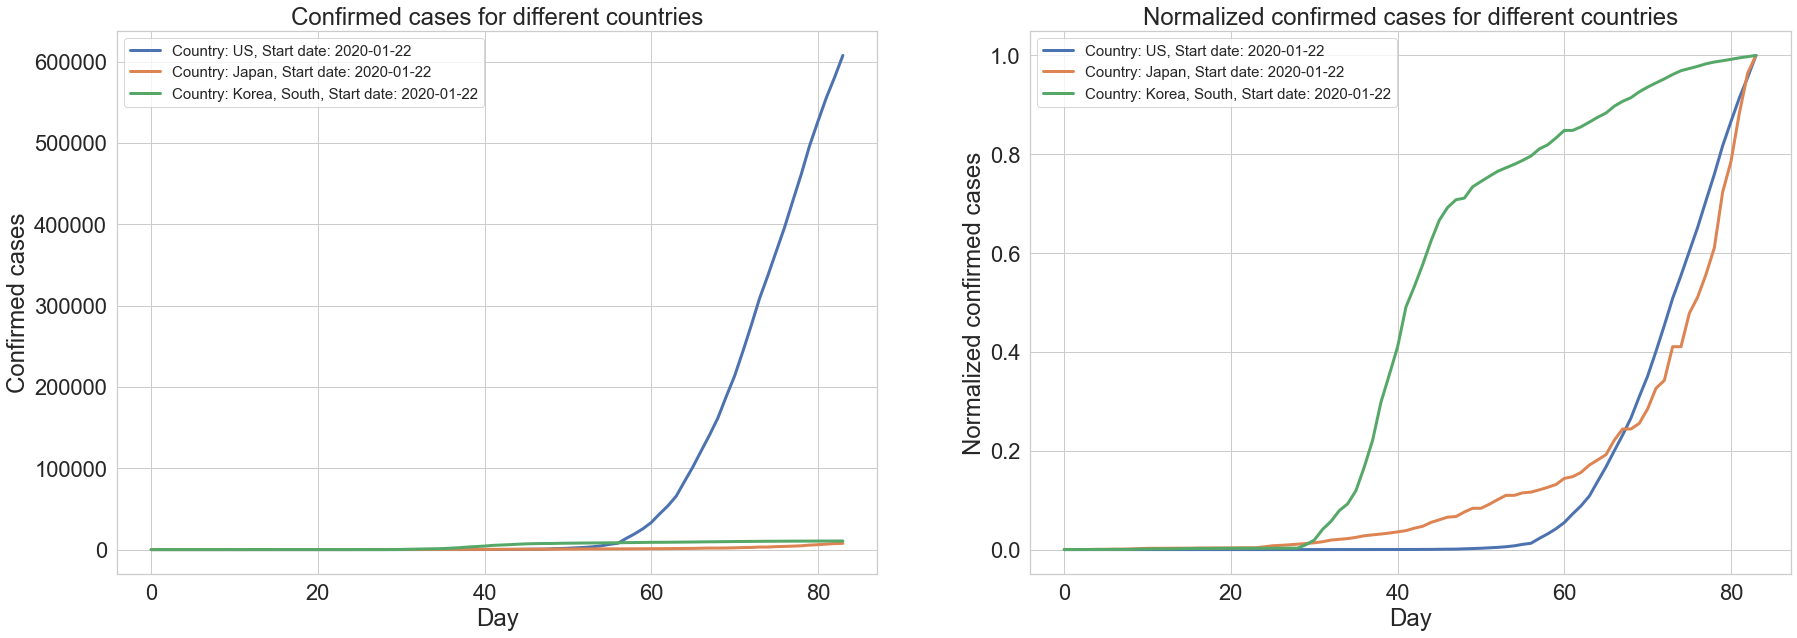

In [1]:
import sys
sys.path.insert(0,'../')

import pandas as pd
import numpy as np
import scipy
import pymc3 as pm
from pymc3.ode import DifferentialEquation
import arviz as az
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

from data import plot_countries_all_plus_normalize_1 as plot
from data import save_country_data_1 as save

# import models
from models import model1, model2, model3

df = pd.read_csv('../../data/datasets/time-series-19-covid-combined.csv')
# plot
plot(df, ['US', 'Japan', 'Korea, South'])
# save data
save(df, ['US', 'Japan', 'Korea, South'])

In [2]:
df_US = pd.read_csv('./US.csv', header=None)
df_Korea = pd.read_csv('./Korea, South.csv', header=None)
df_Japan = pd.read_csv('./Japan.csv', header=None)

Spliting the data into calibration and validation for the various countries. The first 50 days are for calibration, and days 51 to 83 are for validation.

In [3]:
calibration_US, validation_US = df_US.iloc[:51], df_US.iloc[51:]
calibration_Korea, validation_Korea = df_Korea.iloc[:51], df_Korea.iloc[51:]
calibration_Japan, validation_Japan = df_Japan.iloc[:51], df_Japan.iloc[51:]

calibration_times = calibration_US[0].to_numpy()
validation_times = validation_US[0].to_numpy()

# Model 1 US

The following code is based on this [tutorial](https://towardsdatascience.com/from-scratch-bayesian-inference-markov-chain-monte-carlo-and-metropolis-hastings-in-python-ef21a29e25a) and the starter code for the models [provided by Prashant.](https://github.com/prashjha/StudyCovid19)

Model 1 is imported from [this file.](./models.py)

The description for model 1 is from [this file.](./Different%20models.ipynb)

Model 1 has two parameters that we need to tune for the scenario, $r$ and $p$. These two parameters together will be represented using $\theta$, where $\theta = (r, p)$


## Noise

We assume Gaussian noise for the model. With an average $\mu = 0$ and a standard deviation $\sigma$, which will be selected during calibration and validation by calculating the standard deviation of the samples for their respective steps.


## Prior

The prior for the parameters in $\theta$ is considered to be uniform.

- $r$ is nonnegative value.
- $p$ is any value $[0, 1]$

We essure that the value for both $r$ and $p$ is valid. If either of the values is not valid it returns zero, otherwise it returns 1.


## Likelihood

We assume a Gaussian likelihood function.

\begin{align}
\pi_{like}(y|\theta) \propto exp[-\frac{||Y-C(\theta)||^2}{2\sigma^2}]
\end{align}

- $C(\theta)$ is the output of the model with parameter $\theta$.
- $||Y-C(\theta)||^2$ is the squred norm of $|Y-C(\theta)|$

We take the logarithm of the likelihood function because it is more efficient.

\begin{align}
\log(\pi_{like}(Y|\theta)) \propto -\frac{1}{2\sigma}\sum_{i=1}^{N} |y_i-C(t_i;\theta)|^2
\end{align}


## Posterior

\begin{align}
\pi_{post}(\theta|Y) = \frac{\pi_{like}(Y|\theta)\pi_{prior}(\theta)}{\pi_{evidence}(Y)}
\end{align}

Since the evidence is very difficult to compute, we use MCMC, so we can simplify.

\begin{align}
\pi_{post}(\theta|Y) \propto \pi_{like}(Y|\theta)\pi_{prior}(\theta)
\end{align}

We take the logarithm because it is more efficient. 

\begin{align}
\log(\pi_{post}(\theta|Y)) \propto log(\pi_{like}(Y|\theta))+log(\pi_{prior}(\theta))
\end{align}

## Calibration

During the calibration step we take the data from the first 50 days and we use it to calibrate the values of the model parameters. The parameters of this model are `r` and `p`. These two parameters together will be represented using $\theta$, where $\theta = (r, p)$

For that we select a transition model to take us from one state to another. The transition model selects the values for `r` and `p` based on the previous value for `r` and `p` and given a reasonable standard deviation. We use a Gaussian/Normal distribution to randomly select the next value for these parameters.

In [106]:
calibration_cases = calibration_US[1].to_numpy()
calibration_noise = np.std(calibration_cases)
n_iter = 50000

In [107]:
transition_model1 = lambda theta: [np.random.normal(theta[0], 0.1), np.random.normal(theta[1], 0.01)]

def prior(theta):
    if (theta[0] < 1.e-5 or theta[1] <= 1.e-5):
        return 1.e-8
    elif theta[1] >= (1 - 1.e-5):
        return 1.e-8
    else:
        return 1

# likelihood
def log_lik(theta, model, t, data, fix_params, noise_sigma):
    # get model output
    C = model(theta, t, fix_params)
    # log likelihood
    b = data - C
    return (-1. / (2. * noise_sigma * noise_sigma)) * np.linalg.norm(data - C) ** 2

def acceptance(theta, theta_new):
    if theta_new > theta:
        return True
    else:
        accept = np.random.uniform(0, 1)
        return (accept < (np.exp(theta_new - theta)))

def metropolis_hastings(model, likelihood, prior, transition_model, param_init, iterations, 
                        t, data, fix_params, acceptance_rule, noise_sigma):
    # likelihood_computer(x,data): returns the likelihood that these parameters generated the data
    # transition_model(x): a function that draws a sample from a symmetric distribution and returns it
    # param_init: a starting sample
    # iterations: number of accepted to generated
    # data: the data that we wish to model
    # acceptance_rule(x,x_new): decides whether to accept or reject the new sample
    x = param_init
    accepted = []
    rejected = []
    num_accepted = []
    for i in range(iterations):
        x_new = transition_model(x)    
        x_lik = likelihood(x, model, t, data, fix_params, noise_sigma)
        x_new_lik = likelihood(x_new, model, t, data, fix_params, noise_sigma) 
        if (acceptance_rule(x_lik + np.log(prior(x)),
                            x_new_lik+np.log(prior(x_new)))):            
            x = x_new
            accepted.append(x_new)
        else:
            rejected.append(x_new)
                
    return np.array(accepted), np.array(rejected)

We run the Metropolis Hastings Algorithm 50,000 times, and we burn the first 80% of the accepted trials.

In [108]:
accepted, rejected = metropolis_hastings(model1, log_lik, prior, transition_model1, [0., 0.], n_iter,
                                         calibration_times, calibration_cases, [1, 100], acceptance, calibration_noise)
print('Number of Accepted out of 50,000 trials: 'len(accepted))
after_burn_in = int(len(accepted) * 0.8)
accepted = accepted.T

4962


In [109]:
r = accepted[0, after_burn_in:]
p = accepted[1, after_burn_in:]
r_average = np.average(r)
r_std = np.std(r)
p_average = np.average(p)
p_std = np.std(p)

R average:  0.16690286727276382
R std:  0.022711900944343656
P average:  0.951582881129396
P std:  0.035793498045220265


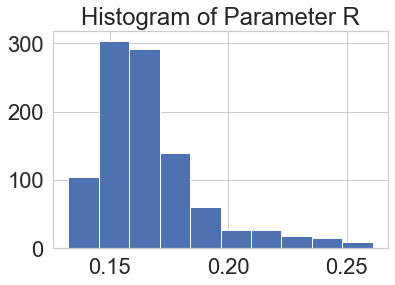

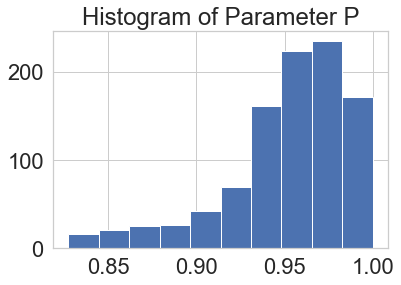

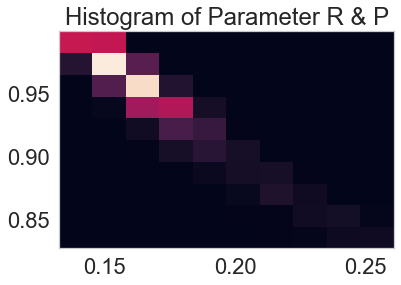

In [110]:
plt.hist(r)
plt.title('Histogram of Parameter R')
plt.figure()
plt.hist(p)
plt.title('Histogram of Parameter P')
plt.figure()
plt.hist2d(r, p)
plt.title('Histogram of Parameter R & P')

print('R average: ', r_average)
print('R std: ', r_std)
print('P average: ', p_average)
print('P std: ', p_std)

In [111]:
t = [float(i) for i in range(84)]
T = 100.
C_0 = 1.

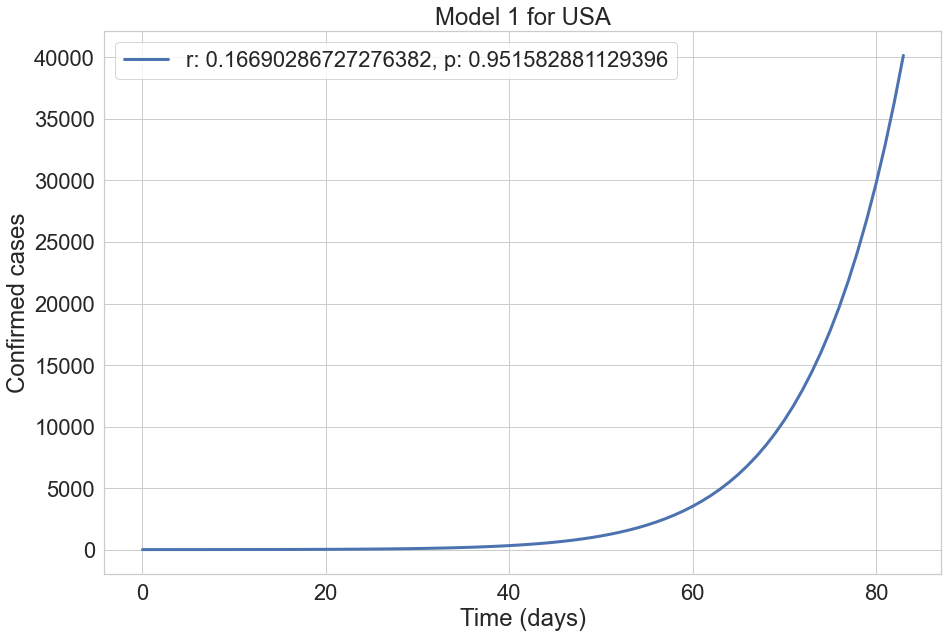

In [112]:
C = model1([r_average, p_average], t, [C_0, T])
fig = plt.figure(figsize=(15., 10.))
plt.plot(t, C, label='r: {}, p: {}'.format(r_average, p_average))
plt.title('Model 1 for USA')
plt.xlabel('Time (days)')
plt.ylabel('Confirmed cases')
plt.legend()

## Validation

In [113]:
validation_cases = validation_US[1].to_numpy()
validation_noise = np.std(calibration_cases)
cov = np.cov([r, p])
mu = np.array([r_average, p_average])

In [114]:
transition_model1 = lambda theta: [np.random.normal(theta[0], r_std), np.random.normal(theta[1], p_std)]

def prior_val(theta):
    if (theta[0] < 1.e-5 or theta[1] <= 1.e-5):
        return 1.e-8
    elif theta[1] >= (1 - 1.e-5):
        return 1.e-8
    else:
        return scipy.stats.multivariate_normal.pdf(theta, mean=mu, cov=cov)

We run the Metropolis Hastings Algorithm 50,000 times, and we burn the first 80% of the accepted trials.

In [115]:
val_accepted, val_rejected = metropolis_hastings(model1, log_lik, prior_val, transition_model1, [r_average, p_average],
                                         n_iter, validation_times, validation_cases, [1, 100], acceptance, validation_noise)
after_burn_in = int(len(val_accepted) * 0.8)
val_accepted = val_accepted.T

In [116]:
val_r = val_accepted[0, after_burn_in:]
val_p = val_accepted[1, after_burn_in:]
val_r_average = np.average(val_r)
val_r_std = np.std(val_r)
val_p_average = np.average(val_p)
val_p_std = np.std(val_p)

R average:  0.3535402831424812
R std:  0.0028372777021852557
P average:  0.8954255806689504
P std:  0.00100220595787011


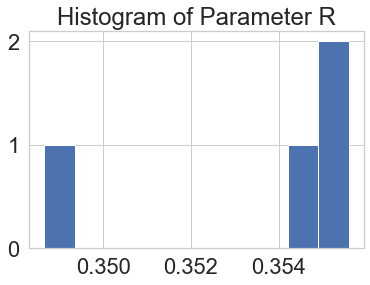

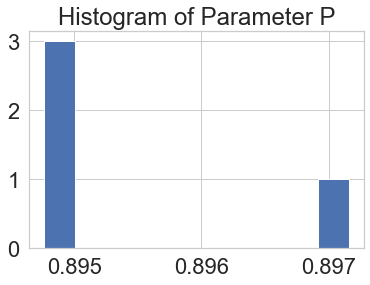

In [117]:
plt.figure()
plt.hist(val_r)
plt.title('Histogram of Parameter R')
plt.figure()
plt.hist(val_p)
plt.title('Histogram of Parameter P')

print('R average: ', val_r_average)
print('R std: ', val_r_std)
print('P average: ', val_p_average)
print('P std: ', val_p_std)

## Prediction

We take the validation parameters and their standard deviations, then we sample a prediction.

In [118]:
def model1_prediction_sampler(theta, theta_std, iterations):
    r = theta[0]
    p = theta[1]
    
    r_std = theta_std[0]
    p_std = theta_std[1]
    
    T = 100
    C_0 = 1
    
    predictions = []
    for i in range(iterations):
        r_i = np.random.normal(r, r_std)
        p_i = np.random.normal(p, p_std)
        prediction = model1([r_i, p_i], [T], [C_0])
        if prediction in [np.inf] or prediction < 0:
            continue
        elif prediction > 1e8:
            continue
        predictions.append(prediction)
        
    return predictions

We run the prediction 50,000 times, and we burn the first 80% of the accepted trials.

In [119]:
predictions = model1_prediction_sampler([val_r_average, val_p_average], [val_r_std, val_p_std], n_iter)

In [120]:
predictions = np.array(predictions)
predictions = predictions.T
after_burn_in = int(len(predictions) * 0.8)
predictions = predictions[after_burn_in:]

In [123]:
print(int(model1([val_r_average, val_p_average], [T], [C_0, T])))
print(int(np.average(predictions)))

2657309
2668655


The prediction from the model using just the validation parameters is 2,657,309 total cases on the 100th day in the US. The prediction from the model using the samples is 2,668,655 total cases on the 100th day in the US.

# References

- **Viboud et al 2015** Viboud, C., Simonsen, L. and Chowell, G., 2016. A generalized-growth model to characterize the early ascending phase of infectious disease outbreaks. Epidemics, 15, pp.27-37.